In [1]:
import numpy as np
import os
import kagglehub
import pandas as pd
from email import message_from_string
from bs4 import BeautifulSoup
from email.header import decode_header
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import requests
import pycountry
import ipaddress
import time
from tqdm import tqdm
from langdetect import detect, DetectorFactory
import pycountry

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

c:\Users\MoffyCream\anaconda3\envs\env1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data collection

In [2]:
# Download latest version
path = kagglehub.dataset_download("beatoa/spamassassin-public-corpus")
print("Path to dataset files:", path)

class SpamAssassinDataset:
    def __init__(self, base_path):
        self.base_path = base_path
        self.spam = []
        self.ham = []
        self.load_data()

    def load_data(self):
        spam_path = os.path.join(self.base_path, "spam_2", "spam_2")
        easy_ham_path = os.path.join(self.base_path, "easy_ham", "easy_ham")
        hard_ham_path = os.path.join(self.base_path, "hard_ham", "hard_ham")

        # Load spam emails
        for filename in os.listdir(spam_path):
            file_path = os.path.join(spam_path, filename)
            try:
                with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
                    self.spam.append(f.read())
            except Exception as e:
                print(f"Error reading spam file {file_path}: {e}")

        # Load easy ham emails
        for ham_path in [easy_ham_path, hard_ham_path]:
            for filename in os.listdir(ham_path):
                file_path = os.path.join(ham_path, filename)
                try:
                    with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
                        self.ham.append(f.read())
                except Exception as e:
                    print(f"Error reading ham file {file_path}: {e}")

    # Return (X, y) where X is the list of emails and y is the labels
    def get_data(self):
        X = self.spam + self.ham
        y = [1] * len(self.spam) + [0] * len(self.ham)  # 1 = spam, 0 = ham
        return np.array(X), np.array(y)

Path to dataset files: C:\Users\MoffyCream\.cache\kagglehub\datasets\beatoa\spamassassin-public-corpus\versions\2


In [3]:
# Load the dataset
dataset = SpamAssassinDataset(path)
X, y = dataset.get_data()

# Load data into df
df = pd.DataFrame({"email": X, "label": y})

# Total number of emails
total_emails = len(df)

# Total number of spam and ham emails
label_counts = df["label"].value_counts()

print("Email Count Summary:")
print(f"Total emails: {total_emails}")
print(f"Spam emails: {label_counts.get(1, 0)}")
print(f"Ham emails: {label_counts.get(0, 0)}")


Email Count Summary:
Total emails: 4198
Spam emails: 1397
Ham emails: 2801


# Data Preprocessing

In [4]:
# Extract subject and body from emails
def extract_subject_body(raw_email):
    try:
        msg = message_from_string(raw_email)
        subject = msg.get("Subject", "")
        body = ""
        if msg.is_multipart():
            for part in msg.walk():
                if part.get_content_type() == "text/plain":
                    body += part.get_payload(decode=True).decode(errors="ignore")
        else:
            body = msg.get_payload(decode=True).decode(errors="ignore")
        return pd.Series([subject, body])
    except:
        return pd.Series(["", ""])

df[["subject", "body"]] = df["email"].apply(extract_subject_body)

print("\nExtracted subjects and bodies:")
print(df[["subject", "body"]].head())


Extracted subjects and bodies:
                                             subject  \
0                       [ILUG] STOP THE MLM INSANITY   
1  Real Protection, Stun Guns!  Free Shipping! Ti...   
2  New Improved Fat Burners, Now With TV Fat Abso...   
3  New Improved Fat Burners, Now With TV Fat Abso...   
4  Never Repay Cash Grants, $500 - $50,000, Secre...   

                                                body  
0  Greetings!\n\nYou are receiving this letter be...  
1  <html>\n<body>\n<center>\n<h3>\n<font color="b...  
2  <html>\n<body>\n<center>\n<b>\n<font color="bl...  
3  <html>\n<body>\n<center>\n<b>\n<font color="bl...  
4  <html><xbody>\n<hr width = "100%">\n<center><h...  


In [5]:
# Strip html tags
def clean_html(raw_html):
    return BeautifulSoup(raw_html, "html.parser").get_text()

# Apply to the body column
df["body_clean"] = df["body"].apply(clean_html)

# Decode email subjects
def decode_subject(raw_subject):
    try:
        decoded_parts = decode_header(raw_subject)
        return ''.join([str(part[0], part[1] or 'utf-8') if isinstance(part[0], bytes) else part[0] for part in decoded_parts])
    except:
        return raw_subject

df["subject"] = df["subject"].apply(decode_subject)

# Show the cleaned subjects and bodies
print("\nCleaned subjects and bodies:")
print(df[["subject", "body_clean"]].head())


Cleaned subjects and bodies:
                                             subject  \
0                       [ILUG] STOP THE MLM INSANITY   
1  Real Protection, Stun Guns!  Free Shipping! Ti...   
2  New Improved Fat Burners, Now With TV Fat Abso...   
3  New Improved Fat Burners, Now With TV Fat Abso...   
4  Never Repay Cash Grants, $500 - $50,000, Secre...   

                                          body_clean  
0  Greetings!\n\nYou are receiving this letter be...  
1  \n\n\n\n\n\nThe Need For Safety Is Real In 200...  
2  \n\n\n\n\n*****Bonus Fat Absorbers As Seen On ...  
3  \n\n\n\n\n*****Bonus Fat Absorbers As Seen On ...  
4  \n\nGovernment Grants E-Book 2002\nedition, Ju...  


In [6]:
# Combine body and subject
def combine_body_subject(subject, body):
    return (subject or "") + " " + (body or "")

df["combined"] = df.apply(lambda row: combine_body_subject(row["subject"], row["body_clean"]), axis=1)

# Check for combined data
print("\nCombined subjects and bodies:")
print(df[["combined"]].head())

# Normalize the combined text
def preprocess_text(text):
    text = text.lower()                                  # Lowercase
    text = re.sub(r"<[^>]+>", " ", text)                 # Remove HTML
    text = re.sub(r"http\S+|www.\S+", " ", text)         # Remove URLs
    text = re.sub(r"[^a-z\s]", " ", text)                # Remove special characters
    text = re.sub(r"\s+", " ", text).strip()             # Remove extra whitespace
    return text

# Apply preprocessing
df["combined_clean"] = df["combined"].apply(preprocess_text)

# Check for cleaned combined data
print("\nCleaned combined subjects and bodies:")
print(df[["combined_clean"]].head())


Combined subjects and bodies:
                                            combined
0  [ILUG] STOP THE MLM INSANITY Greetings!\n\nYou...
1  Real Protection, Stun Guns!  Free Shipping! Ti...
2  New Improved Fat Burners, Now With TV Fat Abso...
3  New Improved Fat Burners, Now With TV Fat Abso...
4  Never Repay Cash Grants, $500 - $50,000, Secre...

Cleaned combined subjects and bodies:
                                      combined_clean
0  ilug stop the mlm insanity greetings you are r...
1  real protection stun guns free shipping time p...
2  new improved fat burners now with tv fat absor...
3  new improved fat burners now with tv fat absor...
4  never repay cash grants secret revealed govern...


# EDA

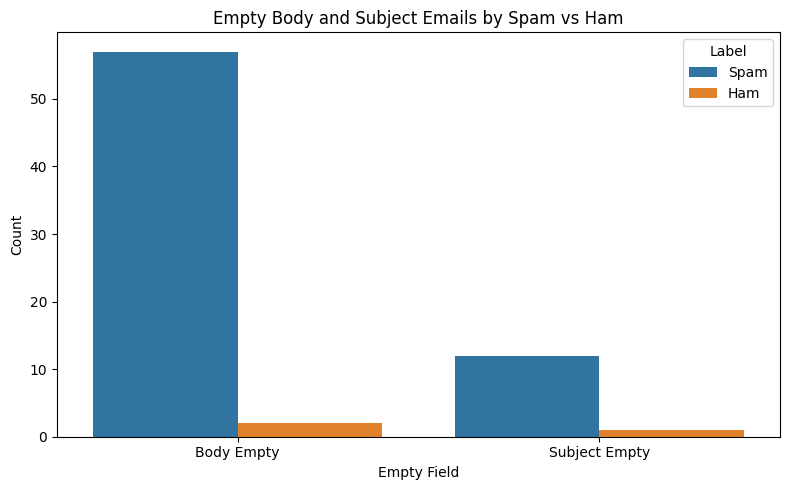

Empty Body Emails:
Spam: 57
Ham: 2

Empty Subject Emails:
Spam: 12
Ham: 1


In [7]:
# Check for empty or broken emails after cleaning
df["is_body_empty"] = df["body_clean"].str.strip() == ""
df["is_subject_empty"] = df["subject"].str.strip() == ""


# Melt the boolean columns to long-form for combined plotting
melted = df.melt(
    id_vars=["label"], 
    value_vars=["is_body_empty", "is_subject_empty"],
    var_name="Empty Type", 
    value_name="Is Empty"
)

# Filter only where empty is True
melted = melted[melted["Is Empty"] == True]

# Convert labels to readable form
melted["Label"] = melted["label"].map({0: "Ham", 1: "Spam"})
melted["Empty Type"] = melted["Empty Type"].map({
    "is_body_empty": "Body Empty", 
    "is_subject_empty": "Subject Empty"
})

# Plot
plt.figure(figsize=(8,5))
sns.countplot(data=melted, x="Empty Type", hue="Label")
plt.title("Empty Body and Subject Emails by Spam vs Ham")
plt.xlabel("Empty Field")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

body_empty_counts = df[df["is_body_empty"]]["label"].value_counts()
print("Empty Body Emails:")
print(f"Spam: {body_empty_counts.get(1, 0)}")
print(f"Ham: {body_empty_counts.get(0, 0)}")

subject_empty_counts = df[df["is_subject_empty"]]["label"].value_counts()
print("\nEmpty Subject Emails:")
print(f"Spam: {subject_empty_counts.get(1, 0)}")
print(f"Ham: {subject_empty_counts.get(0, 0)}")


In [8]:
# Check for empty combined data
df["is_combined_empty"] = df["combined_clean"].str.strip() == ""

# Count empty combined emails
combined_empty_counts = df[df["is_combined_empty"]]["label"].value_counts()
print("\nEmpty Combined Emails:")
print(f"Spam: {combined_empty_counts.get(1, 0)}")
print(f"Ham: {combined_empty_counts.get(0, 0)}")


Empty Combined Emails:
Spam: 11
Ham: 0


In [9]:
# Rank the words in the emails
def get_top_meaningful_words(text_series, n=20):
    words = " ".join(text_series).split()
    # remove one-character words
    words = [word for word in words if len(word) > 1 and word not in ENGLISH_STOP_WORDS]
    return Counter(words).most_common(n)

# Re-run without stopwords
spam_words_clean = get_top_meaningful_words(df[df["label"] == 1]["combined_clean"])
ham_words_clean = get_top_meaningful_words(df[df["label"] == 0]["combined_clean"])

# Show the top words
print("\nTop Spam Words:")
for word, count in spam_words_clean:
    print(f"{word}: {count}")

print("\nTop Ham Words:")
for word, count in ham_words_clean:
    print(f"{word}: {count}")



Top Spam Words:
email: 2174
free: 1997
click: 1483
mv: 1410
business: 1259
mail: 1153
money: 1128
list: 1018
information: 977
time: 940
address: 931
order: 887
com: 867
just: 863
people: 842
new: 810
send: 806
receive: 775
make: 755
home: 714

Top Ham Words:
list: 1874
com: 1864
new: 1628
just: 1587
use: 1465
like: 1356
time: 1314
net: 1237
don: 1098
linux: 1082
people: 1070
mail: 1061
wrote: 973
date: 951
message: 941
web: 918
world: 909
free: 908
users: 907
said: 903


In [10]:
# Use top words to categorize spam
def categorize_spam(text):
    text = text.lower()
    
    if any(word in text for word in ["bitcoin", "crypto", "investment", "blockchain", "wallet", "nft"]):
        return "Crypto Scam"
    
    elif any(word in text for word in ["prize", "win", "winner", "congratulations", "free", "money", "lottery", "reward"]):
        return "Lottery/Prize Scam"
    
    elif any(word in text for word in ["click", "verify", "account", "update", "password", "security", "login", "reset", "suspend"]):
        return "Phishing"
    
    elif any(word in text for word in ["promotion", "business", "offer", "order", "deal", "limited time", "discount"]):
        return "Advertising"
    
    elif any(word in text for word in ["xxx", "adult", "sex", "porn", "nude", "hot girls", "cam", "escort", "explicit"]):
        return "Porn/Adult Spam"
    
    else:
        return "General Spam"


# Apply only to spam-labeled rows
df["spam_type"] = df.apply(lambda row: categorize_spam(row["combined_clean"]) if row["label"] == 1 else "Ham", axis=1)

# Show the spam types
print("\nSpam Types:")
print(df["spam_type"].value_counts())


Spam Types:
spam_type
Ham                   2801
Lottery/Prize Scam     781
Phishing               264
General Spam           155
Crypto Scam            119
Advertising             64
Porn/Adult Spam         14
Name: count, dtype: int64


In [11]:
# 1. Extract sender IP for spam emails
def extract_sender_ip(email_raw):
    try:
        msg = message_from_string(email_raw)
        headers = msg.get_all("Received", [])
        if headers:
            header_str = " ".join(headers)
            ips = re.findall(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b', header_str)
            if ips:
                return ips[-1]
        return None
    except:
        return None

df["sender_ip"] = df.apply(
    lambda row: extract_sender_ip(row["email"]) if row["label"] == 1 else None,
    axis=1
)

# 2. Batch country lookup
def get_countries_batch(ips):
    url = "http://ip-api.com/batch?fields=countryCode"
    results = []
    for i in tqdm(range(0, len(ips), 100)):
        chunk = ips[i:i+100]
        try:
            response = requests.post(url, json=chunk.tolist(), timeout=10)
            if response.status_code == 200:
                results.extend([entry.get("countryCode", "Unknown") for entry in response.json()])
            else:
                results.extend(["Unknown"] * len(chunk))
        except Exception as e:
            print(f"Batch failed: {e}")
            results.extend(["Unknown"] * len(chunk))
        time.sleep(1.5)
    return results

unique_ips = df[df["label"] == 1]["sender_ip"].dropna().unique()
batch_country_codes = get_countries_batch(unique_ips)
ip_to_country = dict(zip(unique_ips, batch_country_codes))
df["country"] = df["sender_ip"].map(ip_to_country)

# 3. Country full name
def get_country_name(code):
    try:
        return pycountry.countries.get(alpha_2=code.upper()).name
    except:
        return "Unknown"

df["country_full"] = df["country"].apply(get_country_name)

# 4. Explain unknown country
def explain_unknown(ip, country):
    if not ip:
        return "Missing IP"
    if country != "Unknown":
        return None
    try:
        ip_obj = ipaddress.ip_address(ip)
        if ip_obj.is_loopback:
            return "Loopback IP"
        elif ip_obj.is_private:
            return "Private IP"
        elif ip_obj.is_reserved:
            return "Reserved IP"
        elif ip_obj.is_unspecified:
            return "Unspecified IP"
        else:
            return "Geo Lookup Failed"
    except:
        return "Malformed IP"

df["unknown_reason"] = df.apply(
    lambda row: explain_unknown(row["sender_ip"], row["country"]) if row["label"] == 1 else None,
    axis=1
)


100%|██████████| 12/12 [00:23<00:00,  1.95s/it]


Top 10 Countries Originating Spam Emails:
country_full
United States                545
China                        117
Unknown                       94
United Kingdom                57
Korea, Republic of            50
Taiwan, Province of China     46
Brazil                        43
Argentina                     37
France                        32
Australia                     26
Name: count, dtype: int64

Breakdown of 'Unknown' Country Causes:
unknown_reason
Private IP           55
Loopback IP          26
Malformed IP         11
Geo Lookup Failed     1
Missing IP            1
Name: count, dtype: int64


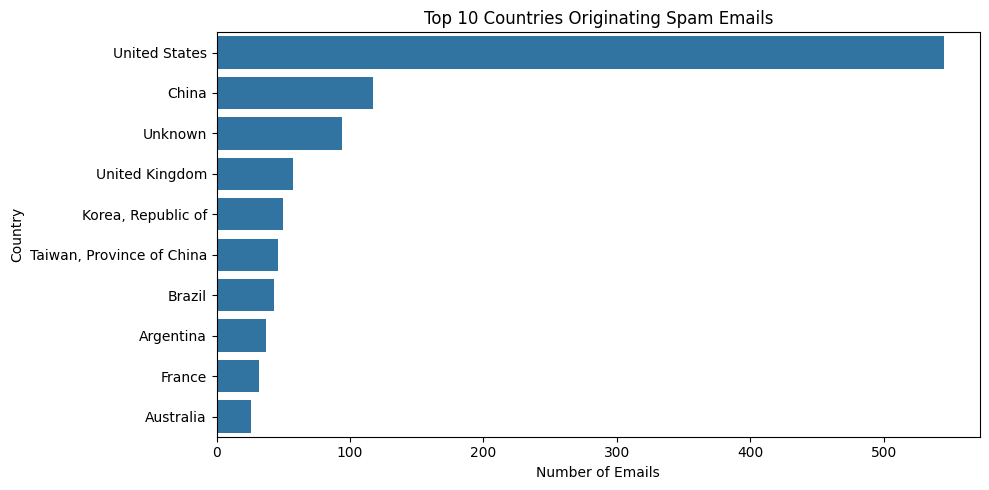

In [12]:
print("Top 10 Countries Originating Spam Emails:")
print(df[df["label"] == 1]["country_full"].value_counts().head(10))

print("\nBreakdown of 'Unknown' Country Causes:")
print(df["unknown_reason"].value_counts())

country_counts = df[df["label"] == 1]["country_full"].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=country_counts.values, y=country_counts.index)
plt.title("Top 10 Countries Originating Spam Emails")
plt.xlabel("Number of Emails")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

In [13]:
# Track the sender domains
def extract_domain(email_raw):
    try:
        msg = message_from_string(email_raw)
        sender = msg.get("From", "")
        # Extract domain after '@'
        domain_match = re.search(r"@([\w.-]+)", sender)
        if domain_match:
            return domain_match.group(1).lower()
        else:
            return None
    except:
        return None
    
df["sender_domain"] = df.apply(
    lambda row: extract_domain(row["email"]) if row["label"] == 1 else None,
    axis=1
)

# Count the top domains
top_domains = df[df["label"] == 1]["sender_domain"].value_counts().head(10)

print("\nTop 10 Sender Domains for Spam Emails:")
print(top_domains)


Top 10 Sender Domains for Spam Emails:
sender_domain
hotmail.com          150
yahoo.com            126
aol.com               60
msn.com               56
insurancemail.net     51
btamail.net.cn        32
mail.com              24
excite.com            22
flashmail.com         20
eudoramail.com        15
Name: count, dtype: int64


In [14]:
# To make results reproducible
DetectorFactory.seed = 0

# Define a function that safely detects language
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

def get_language_name(lang_code):
    try:
        # pycountry uses ISO 639-1 codes for languages
        lang = pycountry.languages.get(alpha_2=lang_code)
        if lang:
            return lang.name
        else:
            return "Unknown"
    except:
        return "Unknown"

# Apply language detection to the combined_clean column
df["lang_code"] = df["combined_clean"].apply(detect_language)
df["language"] = df["lang_code"].apply(get_language_name)

# Count the occurrences of each language
language_counts = df["language"].value_counts()
print("\nLanguage Detection Results:")
print(language_counts)


Language Detection Results:
language
English                    4113
French                       12
Unknown                      11
Turkish                       9
German                        6
Afrikaans                     5
Italian                       5
Portuguese                    4
Dutch                         4
Polish                        3
Croatian                      3
Swahili (macrolanguage)       3
Welsh                         3
Catalan                       2
Norwegian                     2
Somali                        2
Indonesian                    2
Slovenian                     2
Spanish                       2
Albanian                      1
Vietnamese                    1
Czech                         1
Slovak                        1
Finnish                       1
Name: count, dtype: int64


# Model Training

In [15]:
# Filter out empty combined emails
df_model = df[~df["is_combined_empty"]]

# Split the dataset into training and testing sets
X = df_model["combined_clean"]
y = df_model["label"]

# Split 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# Show the size of the training and testing sets
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression())  # or LogisticRegression()
])

# Define common param grid for TF-IDF part (can be shared)
param_grid_common = {
    "tfidf__max_features": [500, 1000, 2000],
    "tfidf__ngram_range": [(1,1), (1,2), (1,3)],
    "tfidf__sublinear_tf": [True, False]
}

# Logistic Regression pipeline and grid
pipeline_lr = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=1000))
])

param_grid_lr = {
    **param_grid_common,
    "clf__C": [0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs"]
}

grid_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=3, scoring="f1", n_jobs=-1)
grid_lr.fit(X_train, y_train)

print("Best params Logistic Regression:", grid_lr.best_params_)
print("Best F1 Logistic Regression:", grid_lr.best_score_)

# Multinomial Naive Bayes pipeline and grid
pipeline_nb = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

param_grid_nb = {
    **param_grid_common,
    "clf__alpha": [1.0, 0.5, 0.1]
}

grid_nb = GridSearchCV(pipeline_nb, param_grid_nb, cv=3, scoring="f1", n_jobs=-1)
grid_nb.fit(X_train, y_train)

print("Best params Naive Bayes:", grid_nb.best_params_)
print("Best F1 Naive Bayes:", grid_nb.best_score_)





Training set size: 3349
Testing set size: 838
Best params Logistic Regression: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 1), 'tfidf__sublinear_tf': True}
Best F1 Logistic Regression: 0.9740003201842732
Best params Naive Bayes: {'clf__alpha': 0.1, 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 1), 'tfidf__sublinear_tf': True}
Best F1 Naive Bayes: 0.9542712171332778


# Model Evaluation (Naive Bayes)

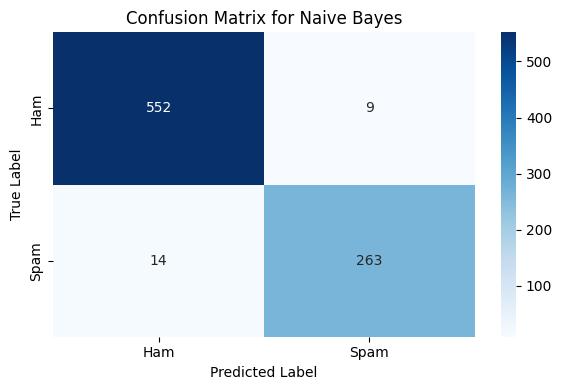


Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.98      0.98       561
        Spam       0.97      0.95      0.96       277

    accuracy                           0.97       838
   macro avg       0.97      0.97      0.97       838
weighted avg       0.97      0.97      0.97       838



In [16]:
# Predict
y_pred_nb = grid_nb.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_nb)
labels = ["Ham", "Spam"]

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix for Naive Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Show classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb, target_names=labels))

In [17]:
# Reset indexes to align properly
X_test_df = X_test
y_test_df = y_test

# Combine into a new DataFrame
test_results = pd.DataFrame({
    "text": X_test,
    "true_label": y_test,
    "predicted_label": y_pred_nb
})

# Filter false negatives (true spam but predicted ham)
false_negatives = test_results[(test_results["true_label"] == 1) & (test_results["predicted_label"] == 0)].copy()

# Join spam_type, is_body_empty, is_subject_empty from original df_model by index
false_negatives = false_negatives.join(
    df_model[["spam_type", "is_body_empty", "is_subject_empty", "sender_domain", "language"]],
    how="left"
)

false_negatives

,text,true_label,predicted_label,spam_type,is_body_empty,is_subject_empty,sender_domain,language
219,good friend nuyiifa s fyqzieec llvt,1,0,General Spam,True,False,many.com,Welsh
937,penile enlarging without surgery,1,0,General Spam,True,False,hotmail.com,English
190,time travelers please help if you are a time t...,1,0,Lottery/Prize Scam,False,False,dk.com,English
407,candidate update dear justin net nation it rec...,1,0,Lottery/Prize Scam,False,False,netnation.ie,English
1045,wm biliyoruz reklama ihtiyaciniz var bunun ici...,1,0,Lottery/Prize Scam,False,False,tr.net.tr,Turkish
869,insight on the news email edition insight news...,1,0,Lottery/Prize Scam,False,False,broadbandpublisher.com,English
57,it s real important that you call we have been...,1,0,General Spam,False,False,excite.com,English
1017,isa article on embedded real time linux automa...,1,0,Phishing,False,False,sixnet-io.com,English
387,cc prevents diesel fuel gelling r rxoo l incre...,1,0,General Spam,False,False,hotmail.com,English
1240,reduction in road accidents,1,0,General Spam,True,False,indiatimes.com,English


In [18]:
# Analyze common words in false negatives
words = " ".join(false_negatives["text"]).lower().split()
words = [w for w in words if len(w) > 2]
common_words = Counter(words).most_common(20)

print("Top words in false negatives (Naive Bayes):")
for word, count in common_words:
    print(f"{word}: {count}")

Top words in false negatives (Naive Bayes):
the: 76
and: 48
you: 23
with: 19
your: 17
this: 15
time: 14
that: 14
for: 14
have: 12
sales: 11
rehber: 11
mail: 11
net: 10
news: 9
from: 9
free: 9
please: 8
are: 8
linux: 8


In [19]:
# Analyze the spam types of false negatives
print("Naive Bayes")
print("\nSpam Types in False Negatives:")
print(false_negatives["spam_type"].value_counts())

# Analyze the sender domains of false negatives (https://mxtoolbox.com/domain/)
print("\nSender Domains in False Negatives:")
print(false_negatives["sender_domain"].value_counts())

Naive Bayes

Spam Types in False Negatives:
spam_type
General Spam          8
Lottery/Prize Scam    5
Phishing              1
Name: count, dtype: int64

Sender Domains in False Negatives:
sender_domain
hotmail.com               2
many.com                  1
dk.com                    1
netnation.ie              1
tr.net.tr                 1
broadbandpublisher.com    1
excite.com                1
sixnet-io.com             1
indiatimes.com            1
dogma.slashnull.org       1
happyman.com              1
up369.com                 1
supper.com                1
Name: count, dtype: int64


In [20]:
best_model = grid_nb.best_estimator_

# Testing the model with real emails
with open("test_ham_email.txt", "r", encoding="utf-8") as f:
    test_ham_email = f.read()

with open("test_spam_email.txt", "r", encoding="utf-8") as f:
    test_spam_email = f.read()

with open("test_spam_email_empty_body.txt", "r", encoding="utf-8") as f:
    test_spam_email_empty_body = f.read()

# Extract and combine subject + body
ham_subject_body = extract_subject_body(test_ham_email)
spam_subject_body = extract_subject_body(test_spam_email)
test_spam_email_empty_body = extract_subject_body(test_spam_email_empty_body)

test_ham_combined = combine_body_subject(ham_subject_body[0], ham_subject_body[1])
test_spam_combined = combine_body_subject(spam_subject_body[0], spam_subject_body[1])
test_spam_email_empty_body_combined = combine_body_subject(test_spam_email_empty_body[0], test_spam_email_empty_body[1])

# Clean the combined text
test_ham_combined_clean = preprocess_text(test_ham_combined)
test_spam_combined_clean = preprocess_text(test_spam_combined)
test_spam_email_empty_body_combined_clean = preprocess_text(test_spam_email_empty_body_combined)

# Predict using the pipeline
ham_pred = best_model.predict([test_ham_combined_clean])
spam_pred = best_model.predict([test_spam_combined_clean])
ham_pred_empty_body = best_model.predict([test_spam_email_empty_body_combined_clean])

ham_proba = best_model.predict_proba([test_ham_combined_clean])[0][0]
spam_proba = best_model.predict_proba([test_spam_combined_clean])[0][1]
ham_proba_empty_body = best_model.predict_proba([test_spam_email_empty_body_combined_clean])[0][1]

# Show results
print("\nTest Emails:")
print(f"Test Ham Email: {test_ham_combined_clean[:100]}...")
print(f"Test Spam Email: {test_spam_combined_clean[:100]}...")

print("\nTest Email Predictions:")
print(f"Test Ham Email Prediction: {'Spam' if ham_pred[0] == 1 else 'Ham'}")
print(f"Test Ham Email Probability: {ham_proba:.4f}")

print(f"Test Spam Email Prediction: {'Spam' if spam_pred[0] == 1 else 'Ham'}")
print(f"Test Spam Email Probability: {spam_proba:.4f}")

print(f"Test Spam Email (Empty Body) Prediction: {'Spam' if ham_pred_empty_body[0] == 1 else 'Ham'}")
print(f"Test Spam Email (Empty Body) Probability: {ham_proba_empty_body:.4f}")



Test Emails:
Test Ham Email: suspicious login detected asobimo inc we have detected that your asobimo account has been logged int...
Test Spam Email: your ticket has been created ticket confirmation hello kelvin lee thian wong your ticket has been su...

Test Email Predictions:
Test Ham Email Prediction: Ham
Test Ham Email Probability: 0.8898
Test Spam Email Prediction: Spam
Test Spam Email Probability: 0.5601
Test Spam Email (Empty Body) Prediction: Ham
Test Spam Email (Empty Body) Probability: 0.1606


# Model Evaluation (Logistic Regression)

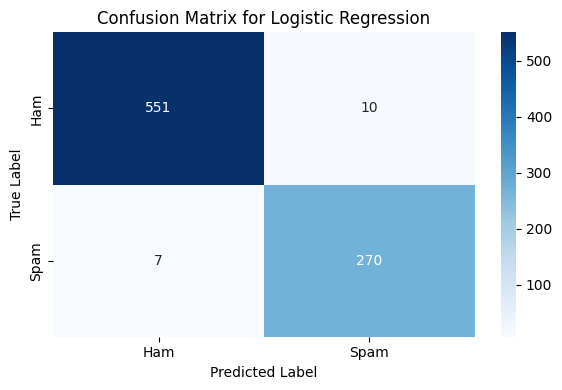


Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.98      0.98       561
        Spam       0.96      0.97      0.97       277

    accuracy                           0.98       838
   macro avg       0.98      0.98      0.98       838
weighted avg       0.98      0.98      0.98       838



In [21]:
# Predict
y_pred_lr = grid_lr.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
labels = ["Ham", "Spam"]

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Show classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=labels))

In [22]:
# Reset indexes to align properly
X_test_df = X_test
y_test_df = y_test

# Combine into a new DataFrame
test_results = pd.DataFrame({
    "text": X_test,
    "true_label": y_test,
    "predicted_label": y_pred_lr
})

# Filter false negatives (true spam but predicted ham)
false_negatives = test_results[(test_results["true_label"] == 1) & (test_results["predicted_label"] == 0)].copy()

# Join spam_type, is_body_empty, is_subject_empty from original df_model by index
false_negatives = false_negatives.join(
    df_model[["spam_type", "is_body_empty", "is_subject_empty", "sender_domain", "language"]],
    how="left"
)

false_negatives

,text,true_label,predicted_label,spam_type,is_body_empty,is_subject_empty,sender_domain,language
190,time travelers please help if you are a time t...,1,0,Lottery/Prize Scam,False,False,dk.com,English
347,male female celebs nude shocking paparrazzi nu...,1,0,Porn/Adult Spam,False,False,netvigator.com,English
869,insight on the news email edition insight news...,1,0,Lottery/Prize Scam,False,False,broadbandpublisher.com,English
1017,isa article on embedded real time linux automa...,1,0,Phishing,False,False,sixnet-io.com,English
483,question from patrick in ireland,1,0,General Spam,True,False,dogma.slashnull.org,English
442,brad pitt caught naked with wife shocking papa...,1,0,Porn/Adult Spam,False,False,andrax.dk,English
218,super news few dodabghzd ow,1,0,General Spam,True,False,supper.com,Welsh


In [23]:
# Analyze common words in false negatives
words = " ".join(false_negatives["text"]).lower().split()
words = [w for w in words if len(w) > 2]
common_words = Counter(words).most_common(20)

print("Top words in false negatives (Logistic Regression):")
for word, count in common_words:
    print(f"{word}: {count}")

Top words in false negatives (Logistic Regression):
the: 56
and: 30
you: 14
that: 11
time: 10
your: 10
with: 10
from: 9
news: 9
have: 8
this: 8
can: 7
nude: 7
jennifer: 7
now: 6
for: 6
celebrity: 6
here: 6
china: 6
please: 5


In [24]:
# Analyze the spam types of false negatives
print("Logistic Regression")
print("\nSpam Types in False Negatives:")
print(false_negatives["spam_type"].value_counts())

# Analyze the sender domains of false negatives (https://mxtoolbox.com/domain/)
print("\nSender Domains in False Negatives:")
print(false_negatives["sender_domain"].value_counts())

Logistic Regression

Spam Types in False Negatives:
spam_type
Lottery/Prize Scam    2
Porn/Adult Spam       2
General Spam          2
Phishing              1
Name: count, dtype: int64

Sender Domains in False Negatives:
sender_domain
dk.com                    1
netvigator.com            1
broadbandpublisher.com    1
sixnet-io.com             1
dogma.slashnull.org       1
andrax.dk                 1
supper.com                1
Name: count, dtype: int64


In [25]:
best_model = grid_lr.best_estimator_

# Testing the model with real emails
with open("test_ham_email.txt", "r", encoding="utf-8") as f:
    test_ham_email = f.read()

with open("test_spam_email.txt", "r", encoding="utf-8") as f:
    test_spam_email = f.read()

with open("test_spam_email_empty_body.txt", "r", encoding="utf-8") as f:
    test_spam_email_empty_body = f.read()

# Extract and combine subject + body
ham_subject_body = extract_subject_body(test_ham_email)
spam_subject_body = extract_subject_body(test_spam_email)
test_spam_email_empty_body = extract_subject_body(test_spam_email_empty_body)

test_ham_combined = combine_body_subject(ham_subject_body[0], ham_subject_body[1])
test_spam_combined = combine_body_subject(spam_subject_body[0], spam_subject_body[1])
test_spam_email_empty_body_combined = combine_body_subject(test_spam_email_empty_body[0], test_spam_email_empty_body[1])

# Clean the combined text
test_ham_combined_clean = preprocess_text(test_ham_combined)
test_spam_combined_clean = preprocess_text(test_spam_combined)
test_spam_email_empty_body_combined_clean = preprocess_text(test_spam_email_empty_body_combined)

# Predict using the pipeline
ham_pred = best_model.predict([test_ham_combined_clean])
spam_pred = best_model.predict([test_spam_combined_clean])
ham_pred_empty_body = best_model.predict([test_spam_email_empty_body_combined_clean])

ham_proba = best_model.predict_proba([test_ham_combined_clean])[0][0]
spam_proba = best_model.predict_proba([test_spam_combined_clean])[0][1]
ham_proba_empty_body = best_model.predict_proba([test_spam_email_empty_body_combined_clean])[0][1]

# Show results
print("\nTest Emails:")
print(f"Test Ham Email: {test_ham_combined_clean[:100]}...")
print(f"Test Spam Email: {test_spam_combined_clean[:100]}...")

print("\nTest Email Predictions:")
print(f"Test Ham Email Prediction: {'Spam' if ham_pred[0] == 1 else 'Ham'}")
print(f"Test Ham Email Probability: {ham_proba:.4f}")

print(f"Test Spam Email Prediction: {'Spam' if spam_pred[0] == 1 else 'Ham'}")
print(f"Test Spam Email Probability: {spam_proba:.4f}")

print(f"Test Spam Email (Empty Body) Prediction: {'Spam' if ham_pred_empty_body[0] == 1 else 'Ham'}")
print(f"Test Spam Email (Empty Body) Probability: {ham_proba_empty_body:.4f}")



Test Emails:
Test Ham Email: suspicious login detected asobimo inc we have detected that your asobimo account has been logged int...
Test Spam Email: your ticket has been created ticket confirmation hello kelvin lee thian wong your ticket has been su...

Test Email Predictions:
Test Ham Email Prediction: Ham
Test Ham Email Probability: 0.8559
Test Spam Email Prediction: Spam
Test Spam Email Probability: 0.6720
Test Spam Email (Empty Body) Prediction: Spam
Test Spam Email (Empty Body) Probability: 0.6062
